In [63]:
import torch
torch.manual_seed(42)

In [64]:
torch.__version__

'2.7.0+cu128'

In [65]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [66]:
import torch.nn as nn

# creating the multihead attention class

In [67]:
class MultiHeadAttention(nn.Module):
    def __init__(self,input_dim,output_dim,context_length,dropout_prob,num_heads,use_qkv_bias=False):
        super().__init__()
        assert (output_dim%num_heads==0),"output_dim must be divisible by num_heads"

        self.output_dim = output_dim
        self.num_heads = num_heads
        self.head_dim = output_dim // num_heads

        self.query_proj = nn.Linear(input_dim,output_dim,bias=use_qkv_bias)
        self.key_proj = nn.Linear(input_dim,output_dim,bias=use_qkv_bias)
        self.value_proj = nn.Linear(input_dim,output_dim,bias=use_qkv_bias)
        self.output_proj = nn.Linear(output_dim, output_dim)
        self.dropout = nn.Dropout(dropout_prob)
        self.register_buffer(
            "causal_mask",torch.triu(torch.ones(context_length,context_length),diagonal=1))

    def forward(self,inputs):
        batch_size,num_tokens,input_dim=inputs.shape

        keys = self.key_proj(inputs)
        queries = self.query_proj(inputs)
        values = self.value_proj(inputs)

        # Reshape for multi-head: (batch_size, num_tokens, num_heads, head_dim)
        keys = keys.view(batch_size,num_tokens,self.num_heads,self.head_dim)
        queries = queries.view(batch_size, num_tokens, self.num_heads, self.head_dim)
        values = values.view(batch_size, num_tokens, self.num_heads, self.head_dim)

         # Transpose for attention: (batch_size, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1,2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Scaled dot-product attention with causal mask
        attn_scores= queries @ keys.transpose(2,3) # (batch_size, num_heads, num_tokens, num_tokens)

        #apply casual mask
        mask = self.causal_mask.bool()[:num_tokens,:num_tokens]
        attn_scores.masked_fill_(mask, -torch.inf)

        attn_weights = torch.softmax(attn_scores / (self.head_dim**0.5), dim=-1)
        attn_weights = self.dropout(attn_weights)

        #compute attention output
        attn_output = (attn_weights @ values).transpose(1,2)

        # Merge heads: (batch_size, num_tokens, output_dim)
        attn_output = attn_output.contiguous().view(batch_size,num_tokens,self.output_dim)
        attn_output = self.output_proj(attn_output)

        return attn_output

# Creating the layernorm

In [68]:
class LayerNorm(nn.Module):
    def __init__(self,emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self,x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True,unbiased=False)
        norm_x = (x-mean) / torch.sqrt(var + self.eps)
        return self.scale* norm_x +self.shift

# Creating GELU

In [69]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self,x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (x + 0.044715 * torch.pow(x, 3))
        ))

# Creating the feedforward class

In [70]:
class FeedForward(nn.Module):
    def __init__(self,cfg):
        super().__init__()

        self.layers = nn.Sequential(
        nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]),
        GELU(),
        nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"]),
        )

    def forward(self,x):
        return self.layers(x)

# Creating transformer class 

In [71]:
class TransformerBlock(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.att = MultiHeadAttention(
        input_dim=cfg["emb_dim"],
        output_dim=cfg["emb_dim"],
        context_length=cfg["context_length"],
        num_heads=cfg["n_heads"],
        dropout_prob=cfg["drop_rate"],
        use_qkv_bias=cfg["qkv_bias"])

        self.ff=FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self,x):
        shortcut = x
        x =self.norm1(x)
        x =self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        
        shortcut = x
        x =self.norm2(x)
        x =self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x

# creating GPT model class

In [72]:
class GPTModel(nn.Module):
    def __init__(self,cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"],cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"],cfg["vocab_size"],bias=False)

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len,device=in_idx.device))
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

# Downloading the pretrained weights

In [73]:
import tensorflow as tf
import tqdm

print("Tensorflow version : ",tf.__version__)
print("tqdm version : ",tqdm.__version__)

Tensorflow version :  2.19.0
tqdm version :  4.67.1


In [74]:
from gpt_weight_download import download_and_load_gpt2

In [75]:
settings, params = download_and_load_gpt2(model_size="355M",models_dir="gpt2")

File already exists and is up-to-date: gpt2/355M/checkpoint


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/encoder.json
File already exists and is up-to-date: gpt2/355M/hparams.json


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/355M/model.ckpt.index


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/355M/model.ckpt.meta
File already exists and is up-to-date: gpt2/355M/vocab.bpe


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [76]:
print("Parameters dictionary keys : ",params.keys())

Parameters dictionary keys :  dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [77]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.0115168   0.00311915 -0.00729894 ... -0.05262156 -0.17569277
   0.02565791]
 [-0.00861426  0.06360211 -0.01822355 ... -0.01364703 -0.12153847
   0.05352487]
 [ 0.05854857  0.06891199  0.02622696 ... -0.10057542 -0.19788682
  -0.0039184 ]
 ...
 [ 0.00162342 -0.04411932 -0.0517492  ... -0.10079621 -0.00865952
   0.02637872]
 [-0.14374605 -0.04632217 -0.00650705 ...  0.07464293 -0.04721651
  -0.03829013]
 [ 0.02065966 -0.01334631 -0.02586888 ...  0.03886637 -0.00233481
   0.00107106]]
Token embedding weight tensor dimensions: (50257, 1024)


In [78]:
print("settings : ",settings)

settings :  {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 1024, 'n_head': 16, 'n_layer': 24}


In [79]:
GPT_CONFIG_355M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 1024, # Shortened context length (orig: 1024)
    "emb_dim": 1024,        # Embedding dimension
    "n_heads": 16,         # Number of attention heads
    "n_layers": 24,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

In [80]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-medium (355M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_355M.copy()
NEW_CONFIG.update(model_configs[model_name])


In [81]:
NEW_CONFIG

{'vocab_size': 50257,
 'context_length': 1024,
 'emb_dim': 1024,
 'n_heads': 16,
 'n_layers': 24,
 'drop_rate': 0.1,
 'qkv_bias': False}

In [82]:
NEW_CONFIG.update({"qkv_bias": True})
gpt = GPTModel(NEW_CONFIG)
gpt.eval();  # In PyTorch, dropout layers are automatically disabled 
             # when the model is in evaluation mode (model.eval()).

In [83]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right : {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

# replacing the parameters of the model with pre-trained weights   

In [84]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    # Assign position and token embeddings
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    # Iterate over transformer blocks
    for b in range(len(params["blocks"])):
        # Load query, key, value projections
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.query_proj.weight = assign(
            gpt.trf_blocks[b].att.query_proj.weight, q_w.T)
        gpt.trf_blocks[b].att.key_proj.weight = assign(
            gpt.trf_blocks[b].att.key_proj.weight, k_w.T)
        gpt.trf_blocks[b].att.value_proj.weight = assign(
            gpt.trf_blocks[b].att.value_proj.weight, v_w.T)

        # Load query, key, value biases
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.query_proj.bias = assign(
            gpt.trf_blocks[b].att.query_proj.bias, q_b)
        gpt.trf_blocks[b].att.key_proj.bias = assign(
            gpt.trf_blocks[b].att.key_proj.bias, k_b)
        gpt.trf_blocks[b].att.value_proj.bias = assign(
            gpt.trf_blocks[b].att.value_proj.bias, v_b)

        # Load output projection weights and biases
        gpt.trf_blocks[b].att.output_proj.weight = assign(
            gpt.trf_blocks[b].att.output_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.output_proj.bias = assign(
            gpt.trf_blocks[b].att.output_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        # Load feed-forward network layers
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        # Load layer normalization parameters
        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    # Load final normalization and output head
    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


In [85]:
device

'cuda'

In [86]:
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [87]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [88]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [89]:
tokenizer = tiktoken.get_encoding("gpt2")

# token_ids = generate_text_simple(
#     model=model,
#     idx=text_to_token_ids("Every effort moves you", tokenizer),
#     max_new_tokens=25,
#     context_size=GPT_CONFIG_124M["context_length"]
# )

# print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

In [90]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you as far as the natural capacity is capable," the lawyer wrote, "which means there's a very small limit (no matter


In [91]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids(r"instruction: Generate detailed chess commentary based on the position information and engine analysis.,input: Position Information:\n- Move: 10. Nf3\n- Turn: Black to move\n- Phase: opening\n- Opening: Queen's Gambit Declined\n- Evaluation: White is ahead by 0.2 pawns\n- Last move connected the rooks", 
                          tokenizer).to(device),
    max_new_tokens=200,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 instruction: Generate detailed chess commentary based on the position information and engine analysis.,input: Position Information:\n- Move: 10. Nf3\n- Turn: Black to move\n- Phase: opening\n- Opening: Queen's Gambit Declined\n- Evaluation: White is ahead by 0.2 pawns\n- Last move connected the rooks as usual, but the queen is already forced to vacillate. By now there's a very small gap (no queens present) where a bishop won't work on black's king. After 10 moves, the situation is now like described below.

It should be of fact that you can consider this line as white loses all two pieces, which results in a 7x7 line-up, although white could've made a stronger line-up. The same was observed in the "Kamenev attack" (with Black at bishop at 14.Qa7 (15...Kc7 16.Ka3Q Kcd3 17.} to secure a position of 6...g5, where black plays h4 into c5 20...g6 21.O-O-O! with b3. At the same moment King comes out at the board and is soon pushed onto f5 in an exchange with Black), as white man

"instruction": "Generate detailed chess commentary based on the position information and engine analysis.",
  "input": "Position Information:\n- Move: 10. Nf3\n- Turn: Black to move\n- Phase: opening\n- Opening: Queen's Gambit Declined\n- Evaluation: White is ahead by 0.2 pawns\n- Last move connected the rooks",

# preparing my data

In [92]:
import json
import torch
from torch.utils.data import Dataset, DataLoader
import tiktoken

In [93]:
with open(r"chess_commentary_cleaned_combined.json", "r") as f:  
    data = json.load(f)


In [94]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    return instruction_text + input_text

In [95]:
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

In [96]:
train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [97]:
class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        self.encoded_texts = []

        for entry in data:
            prompt = format_input(entry)
            response = f"\n\n### Response:\n{entry['output']}"
            full_text = prompt + response
            self.encoded_texts.append(tokenizer.encode(full_text))

    def __getitem__(self, idx):
        return self.encoded_texts[idx]

    def __len__(self):
        return len(self.encoded_texts)

In [98]:
tokenizer = tiktoken.get_encoding("gpt2")
pad_token_id = tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"})[0]

In [99]:
device

'cuda'

In [100]:
def custom_collate_fn(batch, pad_token_id=pad_token_id, ignore_index=-100, allowed_max_length=None, device="cpu"):
    batch_max_length = max(len(item) + 1 for item in batch)  # +1 for <|endoftext|>

    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item + [pad_token_id]  # add endoftext
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))

        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        # Mask padding tokens after the first
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # Optional truncation
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    return torch.stack(inputs_lst).to(device), torch.stack(targets_lst).to(device)

In [101]:
from functools import partial

# Customize the collate function by pre-setting `device` and `allowed_max_length`
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)


In [102]:
from torch.utils.data import DataLoader
import torch

# GPU setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Settings
num_workers = 0
batch_size = 8
torch.manual_seed(123)

# Use the GPU for data collation
collate_fn = lambda batch: custom_collate_fn(batch, device=device)

# Train loader
train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

# Validation loader
val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

# Test loader
test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)


In [103]:
len(train_dataset)

23385

In [104]:
print(data[0])

{'instruction': 'Provide real-time chess commentary. Be concise and casual. Mention checks, mistakes, and who is winning.', 'input': 'MoveNumber: 1 | Move: f3 | CurrentPlayer: White | Phase: Opening | Classification: Excellent move | MateThreat: No immediate mate threat detected | Captured: P | MoveType: capture | Check: No | Checkmate: No | GameOver: No | GameOverReason: Game continues | Winner: None', 'output': 'Okay, here we go! White starts with f3, okay, a bit unusual. Black has a slight advantage early on.'}


In [105]:
# def calc_loss_batch(input_batch, target_batch, model, device):
#     input_batch, target_batch = input_batch.to(device), target_batch.to(device)
#     logits = model(input_batch)
#     loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
#     return loss


# def calc_loss_loader(data_loader, model, device, num_batches=None):
#     total_loss = 0.
#     if len(data_loader) == 0:
#         return float("nan")
#     elif num_batches is None:
#         num_batches = len(data_loader)
#     else:
#         # Reduce the number of batches to match the total number of batches in the data loader
#         # if num_batches exceeds the number of batches in the data loader
#         num_batches = min(num_batches, len(data_loader))
#     for i, (input_batch, target_batch) in enumerate(data_loader):
#         if i < num_batches:
#             loss = calc_loss_batch(input_batch, target_batch, model, device)
#             total_loss += loss.item()
#         else:
#             break
#     return total_loss / num_batches

    
# def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
#                        eval_freq, eval_iter, start_context, tokenizer, max_grad_norm=1.0):
#     train_losses, val_losses, track_tokens_seen = [], [], []
#     tokens_seen, global_step = 0, -1

#     for epoch in range(num_epochs):
#         model.train()
#         for input_batch, target_batch in train_loader:
#             input_batch, target_batch = input_batch.to(device), target_batch.to(device)
#             optimizer.zero_grad()

#             loss = calc_loss_batch(input_batch, target_batch, model, device)
#             loss.backward()

#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
#             optimizer.step()

#             tokens_seen += input_batch.numel()
#             global_step += 1

#             if global_step % eval_freq == 0:
#                 train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
#                 train_losses.append(train_loss)
#                 val_losses.append(val_loss)
#                 track_tokens_seen.append(tokens_seen)
#                 print(f"Ep {epoch+1} (Step {global_step:06d}): "
#                       f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

#         # Optional: Print a sample text after each epoch
#         generate_and_print_sample(model, tokenizer, device, start_context)

#     return train_losses, val_losses, track_tokens_seen


In [106]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)  # Ensure logits are being returned by your model
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer, max_grad_norm=1.0):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        for input_batch, target_batch in train_loader:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)
            optimizer.zero_grad()

            loss = calc_loss_batch(input_batch, target_batch, model, device)  # Calculate batch loss
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)  # Clip gradients if necessary
            optimizer.step()  # Update model parameters

            tokens_seen += input_batch.numel()  # Track the number of tokens processed
            global_step += 1

            # Evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Optional: Generate sample after each epoch
        # generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen


In [107]:
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

In [108]:
model=gpt
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 4.011492967605591
Validation loss: 4.025541019439697


In [109]:
# import time

# start_time = time.time()

# torch.manual_seed(123)

# optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

# num_epochs = 1

# train_losses, val_losses, tokens_seen = train_model_simple(
#     model, train_loader, val_loader, optimizer, device,
#     num_epochs=num_epochs, eval_freq=5, eval_iter=5,
#     start_context=format_input(val_data[0]), tokenizer=tokenizer
# )

# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")

In [110]:
# import torch
# import time

# # 1. Save Checkpoint Function
# def save_checkpoint(epoch, model, optimizer, loss, checkpoint_path):
#     checkpoint = {
#         'epoch': epoch,
#         'model_state_dict': model.state_dict(),
#         'optimizer_state_dict': optimizer.state_dict(),
#         'loss': loss
#     }
#     torch.save(checkpoint, checkpoint_path)
#     print(f"Checkpoint saved at epoch {epoch}.")

# # 2. Load Checkpoint Function
# def load_checkpoint(checkpoint_path, model, optimizer):
#     checkpoint = torch.load(checkpoint_path)
#     model.load_state_dict(checkpoint['model_state_dict'])
#     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
#     start_epoch = checkpoint['epoch']
#     return start_epoch, checkpoint['loss']

# # 3. Evaluate and Generate Sample (Dummy placeholders; replace with actual logic)
# def evaluate_model(model, train_loader, val_loader, device, eval_iter):
#     # Dummy evaluation logic
#     return 0.5, 0.5  # Replace with actual loss computation

# def generate_and_print_sample(model, tokenizer, device, start_context):
#     print("[Sample generation not implemented]")  # Replace with actual generation logic

# def calc_loss_batch(input_batch, target_batch, model, device):
#     input_batch, target_batch = input_batch.to(device), target_batch.to(device)
#     output = model(input_batch)
#     loss_fn = torch.nn.CrossEntropyLoss()
#     return loss_fn(output.view(-1, output.size(-1)), target_batch.view(-1))

# # 4. Training Function with Time Tracking
# def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
#                        eval_freq, eval_iter, start_context, tokenizer, max_grad_norm=1.0):
#     train_losses, val_losses, track_tokens_seen = [], [], []
#     tokens_seen, global_step = 0, -1
#     total_steps = len(train_loader) * num_epochs

#     print(f"Training for {num_epochs} epochs ({len(train_loader)} steps per epoch)...")

#     start_time = time.time()

#     for epoch in range(num_epochs):
#         model.train()
#         epoch_start = time.time()

#         for batch_idx, (input_batch, target_batch) in enumerate(train_loader):
#             optimizer.zero_grad()
#             loss = calc_loss_batch(input_batch, target_batch, model, device)
#             loss.backward()
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
#             optimizer.step()

#             tokens_seen += input_batch.numel()
#             global_step += 1

#             # Evaluation
#             if global_step % eval_freq == 0:
#                 train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
#                 train_losses.append(train_loss)
#                 val_losses.append(val_loss)
#                 track_tokens_seen.append(tokens_seen)
#                 print(f"Ep {epoch+1} (Step {global_step:06d}): "
#                       f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

#         epoch_end = time.time()
#         epoch_duration = epoch_end - epoch_start
#         total_elapsed = epoch_end - start_time
#         remaining_epochs = num_epochs - (epoch + 1)
#         eta_total = remaining_epochs * epoch_duration

#         print(f"Epoch {epoch + 1} completed in {epoch_duration:.2f} seconds "
#               f"({epoch_duration/60:.2f} minutes).")
#         print(f"Estimated total time remaining: {eta_total/60:.2f} minutes.\n")

#         # Save checkpoint
#         checkpoint_path = f"checkpoint_epoch_{epoch + 1}.pt"
#         save_checkpoint(epoch + 1, model, optimizer, loss.item(), checkpoint_path)

#         # Generate text sample
#         generate_and_print_sample(model, tokenizer, device, start_context)

#     total_time = time.time() - start_time
#     print(f"\nTraining completed in {total_time/60:.2f} minutes.")

#     return train_losses, val_losses, track_tokens_seen

# # 5. Start Training Script

# # Set seed
# torch.manual_seed(123)

# # Optimizer
# optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

# # Number of epochs
# num_epochs = 1  # or more, e.g. 5

# # Start training
# train_losses, val_losses, tokens_seen = train_model_simple(
#     model, train_loader, val_loader, optimizer, device,
#     num_epochs=num_epochs, eval_freq=5, eval_iter=5,
#     start_context=format_input(val_data[0]), tokenizer=tokenizer
# )


In [111]:
# import time

# start_time = time.time()

# torch.manual_seed(123)

# optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

# num_epochs = 1

# train_losses, val_losses, tokens_seen = train_model_simple(
#     model, train_loader, val_loader, optimizer, device,
#     num_epochs=num_epochs, eval_freq=5, eval_iter=5,
#     start_context=format_input(val_data[0]), tokenizer=tokenizer
# )

# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"Training completed in {execution_time_minutes:.2f} minutes.")

In [112]:
!pip install time

ERROR: Could not find a version that satisfies the requirement time (from versions: none)

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
ERROR: No matching distribution found for time


In [113]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

In [114]:
import time
import torch

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 1

train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

# Save the model after training
model_save_path = 'trained_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Ep 1 (Step 000000): Train loss 3.065, Val loss 3.087
Ep 1 (Step 000005): Train loss 1.020, Val loss 1.028
Ep 1 (Step 000010): Train loss 0.719, Val loss 0.650
Ep 1 (Step 000015): Train loss 0.603, Val loss 0.606
Ep 1 (Step 000020): Train loss 0.634, Val loss 0.584
Ep 1 (Step 000025): Train loss 0.609, Val loss 0.563
Ep 1 (Step 000030): Train loss 0.572, Val loss 0.539
Ep 1 (Step 000035): Train loss 0.568, Val loss 0.517
Ep 1 (Step 000040): Train loss 0.552, Val loss 0.505
Ep 1 (Step 000045): Train loss 0.558, Val loss 0.497
Ep 1 (Step 000050): Train loss 0.557, Val loss 0.501
Ep 1 (Step 000055): Train loss 0.514, Val loss 0.492
Ep 1 (Step 000060): Train loss 0.490, Val loss 0.477
Ep 1 (Step 000065): Train loss 0.488, Val loss 0.472
Ep 1 (Step 000070): Train loss 0.514, Val loss 0.475
Ep 1 (Step 000075): Train loss 0.493, Val loss 0.467
Ep 1 (Step 000080): Train loss 0.472, Val loss 0.458
Ep 1 (Step 000085): Train loss 0.491, Val loss 0.454
Ep 1 (Step 000090): Train loss 0.483, Val loss

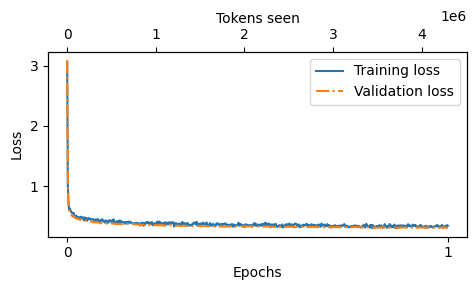

In [115]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [116]:
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()  # Set the model to evaluation mode


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (output_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (query_